In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.car import car_init
from probDE.utils.utils import rand_mat, indep_init
from scipy.integrate import odeint
from probDE.cython.KalmanODE import KalmanODE as KalmanODE_blas
from probDE.tests.KalmanODE import KalmanODE
from KalmanODE_py import KalmanODE_py

In [2]:
from math import sin
from scipy import integrate
def ode_py(x_t, t, theta=None):
    return np.array([sin(2*t) - x_t[0]])

# ode function in odeint format
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [25]:
# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .5

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
kinit, x0_state = indep_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)

In [26]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit)
kalmanode.z_states = z_states
kalman_sim, _, _ = kalmanode.solve(x0_state, mv=True, sim=True)

In [27]:
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
k_sim, k_mu, k_var = kalmanode_py.solve(x0_state, mv=True, sim=True)

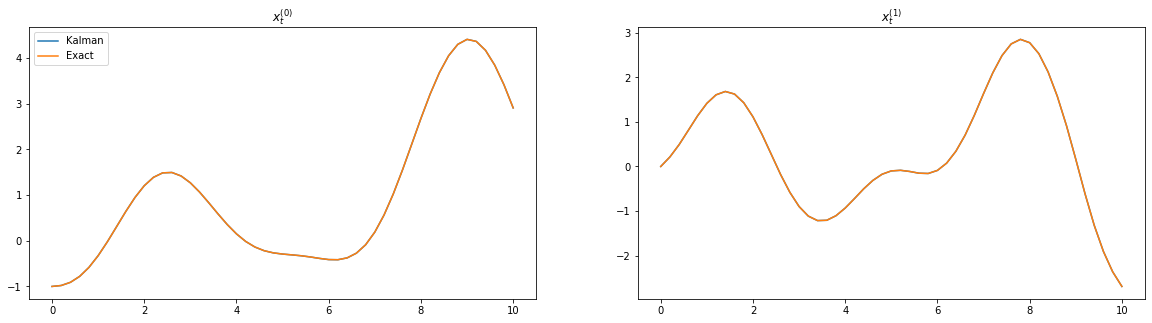

In [28]:
tseq = np.linspace(tmin, tmax, n_eval+1)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, k_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, kalman_sim[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, k_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, kalman_sim[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [33]:
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_c = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

313 µs ± 38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_cy = %timeit -o -n 100 _ = kalmanode.solve(x0_state, mv=False, sim=True)

927 µs ± 26 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, ode_py, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py = %timeit -o -n 100 _ = kalmanode_py.solve(x0_state, mv=False, sim=True)

9.16 ms ± 396 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = %timeit -o ode = integrate.odeint(f, [-1, 0], tseq)

550 µs ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
print("Cython is {}x faster than Python".format(kalman_py.average/kalman_cy.average))
print("C++ is {}x faster than Python".format(kalman_py.average/kalman_c.average))

Cython is 9.886346833438497x faster than Python
C++ is 29.254039854686987x faster than Python


## Lorenz63

In [18]:
def lorenz0(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    x, y, z = X_t[0], X_t[1], X_t[2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y]) 

In [64]:
# RHS of ODE
def lorenz(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 2
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y])

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 6 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 2
n_var_states = np.array([n_state1, n_state2, n_state3])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 5000
tmin = 0
tmax = 20
theta=(28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

In [65]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                        car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1]),
                        car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], x0[2])], n_state)

# Initialize the Kalman class
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

In [66]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode_c = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_lor_c = %timeit -o _ = kalmanode_c.solve(x0_state, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit)
kalmanode.z_states = z_states
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, theta, mv=False, sim=True)
print('py/cy: {}'.format(kalman_lor_py.average/kalman_lor_cy.average))
print('py/c: {}'.format(kalman_lor_py.average/kalman_lor_c.average))

57.5 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
101 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
958 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
py/cy: 9.486268398815659
py/c: 16.647218021299466


# Fitz model

In [39]:
def fitz(X_t, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    n_state1 = len(X_t)//2
    V, R = X_t[0], X_t[n_state1] 
    return np.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])

In [73]:
n_state = 6 # Total state
n_state1 = n_state2 = 3
n_meas = 2 # Total measures
state_ind = [0, 3]

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
h = 0.1 # step size
n_eval = int((tmax-tmin)/h)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([1, 1/3])
X0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])
theta = np.array([0.2, 0.2, 3])


In [74]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], X0[0]),
                              car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], X0[1])],
                              n_state)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, fitz, **kinit)
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_fitz_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

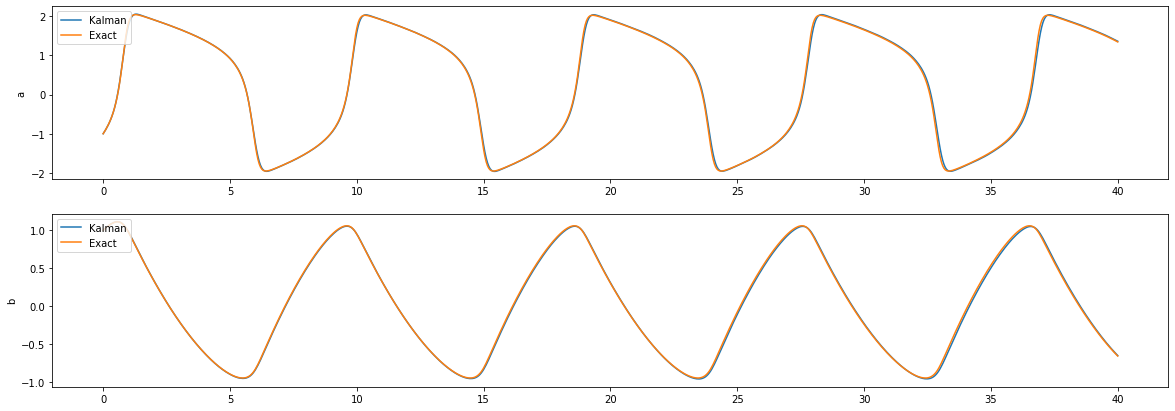

In [46]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz, X0[:, 0], tseq, args=(theta,))

_, axs = plt.subplots(n_meas, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_meas):
    axs[i].plot(tseq, kalman_fitz_sim[:, n_state1*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [75]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode_c = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_fitz_c = %timeit -o _ = kalmanode_c.solve(x0_state, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_states = z_states
kalman_fitz_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_fitz_py = %timeit -o _ = kalmanode_py.solve(x0_state, theta, mv=False, sim=True)
print('py/cy: {}'.format(kalman_fitz_py.average/kalman_fitz_cy.average))
print('py/c: {}'.format(kalman_fitz_py.average/kalman_fitz_c.average))

4.37 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.56 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
82.9 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
py/cy: 8.66795417374728
py/c: 18.949772436982368


# MSEIR model

In [49]:
print('py/cy: {}'.format(kalman_fitz_py.average/kalman_fitz_cy.average))
print('py/c: {}'.format(kalman_fitz_py.average/kalman_fitz_c.average))

py/cy: 8.420045687629203
py/c: 18.780686003340872


We will look at a multivariate ODE system called **MSEIR model**. This model is used in epidemiology where<br/>
M = Maternally-derived Immunity<br/>
S = Susceptible<br/>
E = Exposed<br/>
I = Infectious<br/>
R = Recovered<br/>

\begin{equation}
  \begin{aligned}
    \frac{dM}{dt} &= \Lambda - \delta M - \mu M \\
    \frac{dS}{dt} &= \delta M- \frac{\beta SI}{N} - \mu S \\
    \frac{dE}{dt} &= \frac{\beta SI}{N} - (\epsilon + \mu)E \\
    \frac{dI}{dt} &= \epsilon E - (\gamma + \mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R
  \end{aligned}
\end{equation}


In [77]:
def mseir(X_t, t, theta):
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    dM = Lambda - delta*M - mu*M
    dS = delta*M - beta*S*I/N - mu*S
    dE = beta*S*I/N - (epsilon + mu)*E
    dI = epsilon*E - (gamma + mu)*I
    dR = gamma*I - mu*R
    return np.array([dM, dS, dE, dI, dR])

In [78]:
# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 5
n_state = 15 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = n_state4 = n_state5 = 3
n_var_states = np.array([n_state1, n_state2, n_state3, n_state4, n_state5])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 500
tmin = 0
tmax = 20
theta = (1, 0.7, 0.4, 0.005, 0.02, 0.035)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([10, 10, 10, 10, 10])
sigma = np.array([.5, .5, .5, .5, .5])

# Initial value, x0, for the IVP
x0 = np.array([1000, 100, 50, 3, 3])
v0 = mseir(x0, 0, theta)
X0 = np.column_stack([x0, v0])

In [79]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], X0[0]),
                              car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], X0[1]),
                              car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], X0[2]),
                              car_init(n_state4, tau[3], sigma[3], dt, w_mat[3], X0[3]),
                              car_init(n_state5, tau[4], sigma[4], dt, w_mat[4], X0[4])], n_state)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, mseir, **kinit)
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_mse_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

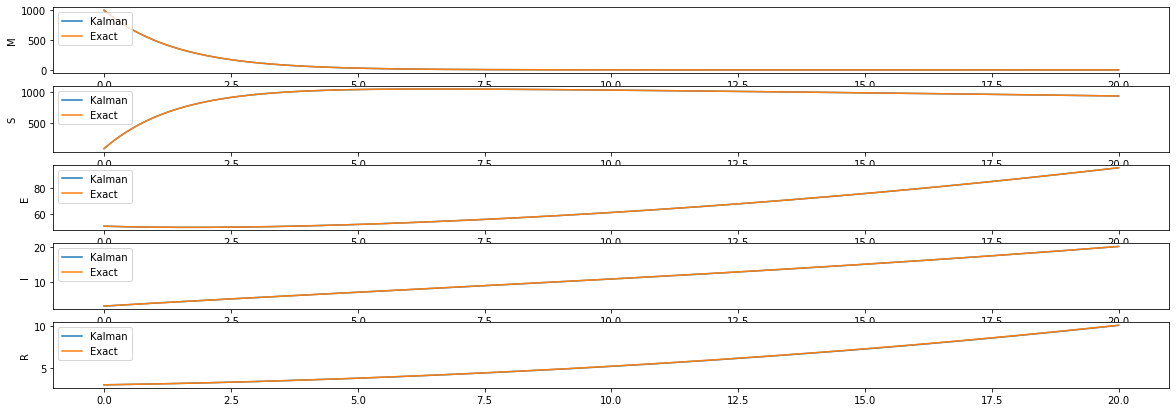

In [80]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(mseir, X0[:, 0], tseq, args=(theta,))

_, axs = plt.subplots(n_meas, 1, figsize=(20, 7))
ylabel = ['M', 'S', 'E', 'I', 'R']
for i in range(n_meas):
    axs[i].plot(tseq, kalman_mse_sim[:, n_state1*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [83]:
z_states = rand_mat(2*(n_eval+1), n_state)
kalmanode_c = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_mse_c = %timeit -o _ = kalmanode_c.solve(x0_state, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_state, n_meas, tmin, tmax, n_eval, mseir, **kinit)
kalmanode.z_states = z_states
kalman_mse_cy = %timeit -o _ = kalmanode.solve(x0_state, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_state, n_meas, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_mse_py = %timeit -o _ = kalmanode_py.solve(x0_state, theta, mv=False, sim=True)
print('py/cy: {}'.format(kalman_mse_py.average/kalman_mse_cy.average))
print('py/c: {}'.format(kalman_mse_py.average/kalman_mse_c.average))

14.1 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.4 ms ± 590 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
108 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
py/cy: 6.214027811319392
py/c: 7.6281559638966385
